## Client Project: Leveraging Social Media to Map Disasters

## 1. EDA and FEMA Disaster Evaluation

### Contents:
- [Problem Statement](#Problem-Statement)
- [Import Packages and Data](#Import-Packages-and-Data)
- [EDA](#EDA)
    - [FEMA](#FEMA)

## Problem Statement

According to the National Oceanic and Atmospheric Administration (NOAA) the amount of billion dollar (adjusted for inflation) natural disasters per year since since 1980 has been on a steady uptrend with 3 of such events in 1980 and 14 in 2019. Although this number has increased dramatically for the United States as well as the rest of the world, the total number of deaths has fallen dramatically. Part of the reason for this is that people are able to recieve alerts and warnings much faster which allows them more time to prepare and evacuate. Many weather organizations have in place systems to alert the public about natural disasters and which areas are affected. But what if there are locations that are out of the system's reach? Can these weather systems always give precise mapping of a storm? What if power goes out in a widespread area causing a system to be delayed or innacurate? In the face of some of these challenges, social media, specifically Twitter, can be leveraged to accurately detect and map various types of natural disasters. Twitter allows us to search for tweets pertaining to the event we are looking to map as well as provide geolocation of where that tweet was sent from, and a timestamp of when the tweet was sent. Using these features we can build a model to validate and then map tweets pertaining to an event. This will ultimately allow for a more up to date service first responders can use to reach isolated civilians in the even of a crisis.

### Import Packages and Data

In [100]:
import twitterscraper
from twitterscraper import query_tweets
import requests
import pandas as pd
import datetime as dt
import warnings
import requests
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
#pip install GetOldTweets3

In [3]:
import GetOldTweets3 as got

In [4]:
#pip install twitterscraper

## EDA

In [5]:
#reading in our scrapped Tweets 
df_wi_tx = pd.read_csv('../Data/df_TX_WI_clean.csv')

In [6]:
df_wi_tx.columns

Index(['Unnamed: 0', 'Date', 'Favorites', 'HashTags', 'Mentions', 'Retweets',
       'Text', 'location', 'target', 'user_split', 'user_text'],
      dtype='object')

In [7]:
df_wi_tx.shape

(2702, 11)

In [8]:
df_wi_tx['Text']

0       Nice to have a positive story about big cats f...
1       my dad just told me to flood my car so I can g...
2                  Happy B-day Reggie, from the office!!!
3       Something about how crime will magically drop ...
4       Lol mine too. I’ve been avoiding floods for th...
                              ...                        
2697    Flash flood watch for Charlotte and eastward u...
2698     Move to higher ground! Flash Flood Warning in...
2699    Help arrives for Greenspoint flood victi http:...
2700    W my fellow Capital Correspondents raising $fo...
2701    Flood party @Charleston, South Carolina https:...
Name: Text, Length: 2702, dtype: object

In [9]:
df_wi_tx.columns

Index(['Unnamed: 0', 'Date', 'Favorites', 'HashTags', 'Mentions', 'Retweets',
       'Text', 'location', 'target', 'user_split', 'user_text'],
      dtype='object')

In [11]:
# create a month, year and date column 
from dateutil.parser import parse
df_wi_tx['Date'] = pd.to_datetime(df_wi_tx['Date'])

df_wi_tx['Month/Year'] = df_wi_tx['Date'].apply(lambda x: "%d/%d" % (x.month, x.year))

df_wi_tx['Month'] = df_wi_tx['Date'].apply(lambda x: "%d" % (x.month))

df_wi_tx['Year'] = df_wi_tx['Date'].apply(lambda x: "%d" % (x.year))


In [12]:
stop = list(stopwords.words('english'))

In [13]:
custom = ['rf','com','lsr', 'edu', 'http' , 'www','usgs', 'instagram','pm', 'co', 'warning', 'amp', 'arx', 'cdt', 
         'ft', 'gov', 'uv', 'nw', 'tx', 'mngr', 'nwis']

In [14]:
# combine the stop with the custom
stop_final = stop + custom

In [15]:
# a function so we can see the frequency of words 
def word_count(list_words):
    cv = CountVectorizer(stop_words = stop_final)
    cv_transform= cv.fit_transform(list_words) # turning it into a vector
    df_word = pd.DataFrame(cv_transform.toarray(),
             columns=cv.get_feature_names()) # creating a dataframe
    df_sorted = pd.DataFrame(df_word.sum().sort_values(ascending=False),
                                  columns=['count'])
    return df_sorted

In [17]:
# a function to clean the words in the string columns
def cleaning_string(string):
    
    #We want letters only
    string = re.sub("[^a-zA-Z]", " ", string) 
    
    #removing hyperlinks
    string = re.sub(r'http\S+', '', string)
    string = re.sub(r'www\S+', '', string)
   
    #converts words to lowercase and splits.
    string = string.lower().split()
    
    #Instantiates lemmatizer and stems words.
    lemmatizer = WordNetLemmatizer()
    string = [lemmatizer.lemmatize(x) for x in string]
    
    #Creating variable form default english stopword list and our own custom stop list.
    stop = set(stopwords.words('english'))
    custom_stop = ['rf','com','lsr', 'edu', 'http' , 'www','usgs', 'co']
                   
    
    #removing stopwords from both the default english set, and our custom stop word list
    string = [x for x in string if not x in stop]
    string = [w for w in string if not w in custom_stop]
    

    #joining words separated by a space and return
    return(" ".join(string))

In [18]:
df_wi_tx['Text']= df_wi_tx['Text'].apply(cleaning_string)

In [19]:
df_count_wi_tx = word_count(df_wi_tx['Text'])

In [20]:
# top fifteen words found in the twitter 
df_count_wi_tx.head(15)

,count
flood,2751
flash,1080
report,959
mesonet,946
iastate,943
agron,943
law,228
enforcement,224
stage,196
including,195


The top words included the key words we searched for such as flood, flash, report. It also included environmental groups and weather organization sites (waterdata).

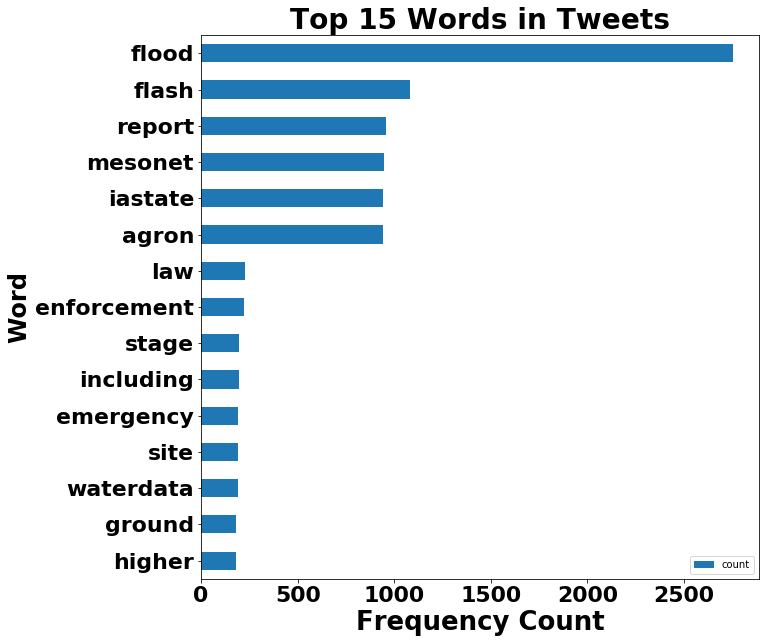

In [21]:
#looking at top tweets
df_count_wi_tx.head(15).plot(kind='barh',figsize=(10,10))
plt.title("Top 15 Words in Tweets", fontsize=28, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Word", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

Not suprising that flood and flash are the top words. Emergency, law, enforcement are all frewuent words expected to come up on the tweets. Waterdata is among the top 15 most frequent words - it is a online resource that provides acess to water resources data. 

In [22]:
df_top_wi = df_count_wi_tx.head(10)

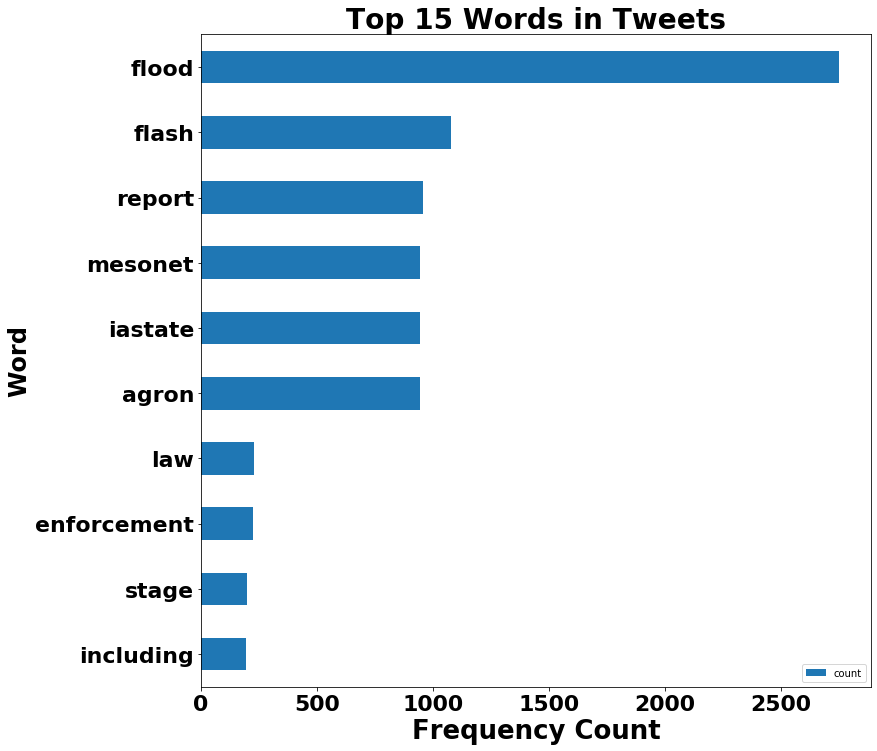

In [23]:
# top tweets in Wisconsin Floods
df_top_wi.head(15).plot(kind='barh',figsize=(12,12))
plt.title("Top 15 Words in Tweets", fontsize=28, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Word", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

## FEMA Data

In order to create a model that validated whether or not a tweet was really about a flood we needed to create data to train on. We used the OPENFema Dataset of Disaster Declaration Summaries to determine which flood tweets from which locations and time ranges would be assigned a target variable of '1' for 'flood' and which tweets would be assigned '0' for no flood or false positive. 

FEMA Disaster Declarations Summary is a dataset that stated all federally declared disasters. It containes information on whether any programs werer declared, the state in which it ocurred, disaster type and declaration date and incident begin and end date.

Below we explored the data set,looked at all the unique titles and the date range for the flood.

In [24]:
df_FEMA_open_data = pd.read_csv('../datasets/DisasterDeclarationsSummaries.csv')

In [25]:
df_FEMA_open_data.head()

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,state,declarationDate,fyDeclared,disasterType,incidentType,title,incidentBeginDate,incidentEndDate,disasterCloseOutDate,declaredCountyArea,placeCode,hash,lastRefresh,id
0,1,0,1,1,1,GA,1953-05-02T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-05-02T00:00:00.000Z,1953-05-02T00:00:00.000Z,1954-06-01T00:00:00.000Z,NaN,NaN,1dcb40d0664d22d39de787b706b0fa69,2019-07-26T18:08:57.368Z,5d1bbd8c8bdcfa6efb32fd8d
1,2,0,1,1,1,TX,1953-05-15T00:00:00.000Z,1953,DR,Tornado,TORNADO & HEAVY RAINFALL,1953-05-15T00:00:00.000Z,1953-05-15T00:00:00.000Z,1958-01-01T00:00:00.000Z,NaN,NaN,61612cea5779e361b429799098974b6a,2019-07-26T18:08:57.370Z,5d1bbd8c8bdcfa6efb32fd8e
2,3,0,1,1,1,LA,1953-05-29T00:00:00.000Z,1953,DR,Flood,FLOOD,1953-05-29T00:00:00.000Z,1953-05-29T00:00:00.000Z,1960-02-01T00:00:00.000Z,NaN,NaN,86f3e47785cb7acc51364d4535d36101,2019-07-26T18:08:57.369Z,5d1bbd8c8bdcfa6efb32fd8f
3,6,0,1,1,1,MI,1953-06-09T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-06-09T00:00:00.000Z,1953-06-09T00:00:00.000Z,1956-03-30T00:00:00.000Z,NaN,NaN,2208518c84c44f8e4164248d47f89ead,2019-07-26T18:08:57.369Z,5d1bbd8c8bdcfa6efb32fd92
4,4,0,1,1,1,MI,1953-06-02T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-06-02T00:00:00.000Z,1953-06-02T00:00:00.000Z,1956-02-01T00:00:00.000Z,NaN,NaN,1dbe5937a01fc74c8e699912e3f555cb,2019-07-26T18:08:57.370Z,5d1bbd8c8bdcfa6efb32fd91


In [26]:
df_FEMA_open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51016 entries, 0 to 51015
Data columns (total 19 columns):
disasterNumber          51016 non-null int64
ihProgramDeclared       51016 non-null int64
iaProgramDeclared       51016 non-null int64
paProgramDeclared       51016 non-null int64
hmProgramDeclared       51016 non-null int64
state                   51016 non-null object
declarationDate         51016 non-null object
fyDeclared              51016 non-null int64
disasterType            51016 non-null object
incidentType            51016 non-null object
title                   51016 non-null object
incidentBeginDate       51016 non-null object
incidentEndDate         50503 non-null object
disasterCloseOutDate    40999 non-null object
declaredCountyArea      50802 non-null object
placeCode               50802 non-null float64
hash                    50943 non-null object
lastRefresh             50943 non-null object
id                      51016 non-null object
dtypes: float64(1), in

In [221]:
df_FEMA_open_data.dtypes

disasterNumber                        int64
ihProgramDeclared                     int64
iaProgramDeclared                     int64
paProgramDeclared                     int64
hmProgramDeclared                     int64
state                                object
declarationDate                      object
fyDeclared                            int64
disasterType                         object
incidentType                         object
title                                object
incidentBeginDate       datetime64[ns, UTC]
incidentEndDate                      object
disasterCloseOutDate                 object
declaredCountyArea                   object
placeCode                           float64
hash                                 object
lastRefresh                          object
id                                   object
Month/Year                           object
Month                                object
Year                         datetime64[ns]
incidentType_2                  

In [27]:
df_fema_flood = df_FEMA_open_data[df_FEMA_open_data['incidentType'] == 'Flood']

In [219]:
df.to_csv('./df_WI_adjusted.csv')

In [28]:
# looking just at Flood 

df_FEMA_open_data[df_FEMA_open_data['disasterNumber']==4459].head()

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,state,declarationDate,fyDeclared,disasterType,incidentType,title,incidentBeginDate,incidentEndDate,disasterCloseOutDate,declaredCountyArea,placeCode,hash,lastRefresh,id
50290,4459,0,0,1,1,WI,2019-08-27T12:42:00.000Z,2019,DR,Flood,"SEVERE STORMS, TORNADOES, STRAIGHT-LINE WINDS,...",2019-07-18T00:00:00.000Z,2019-07-20T00:00:00.000Z,NaN,NaN,NaN,a8699eb216cb2ee05a7107b5ba7bf02c,2019-08-27T22:01:34.178Z,5d65a83ef8b9013665b3a06d
50291,4459,0,0,1,1,WI,2019-08-27T12:42:00.000Z,2019,DR,Flood,"SEVERE STORMS, TORNADOES, STRAIGHT-LINE WINDS,...",2019-07-18T00:00:00.000Z,2019-07-20T00:00:00.000Z,NaN,Barron (County),99005.0,8f0aa791f30ab798f332ef9dd29471f1,2019-10-10T19:57:09.215Z,5d65acb8f8b9013665b3a35e
50292,4459,0,0,1,1,WI,2019-08-27T12:42:00.000Z,2019,DR,Flood,"SEVERE STORMS, TORNADOES, STRAIGHT-LINE WINDS,...",2019-07-18T00:00:00.000Z,2019-07-20T00:00:00.000Z,NaN,Vernon (County),99123.0,d51cfed668da13bc7c7a6b783f64c057,2019-10-10T19:57:09.143Z,5d65acb8f8b9013665b3a364
50293,4459,0,0,1,1,WI,2019-08-27T12:42:00.000Z,2019,DR,Flood,"SEVERE STORMS, TORNADOES, STRAIGHT-LINE WINDS,...",2019-07-18T00:00:00.000Z,2019-07-20T00:00:00.000Z,NaN,Clark (County),99019.0,b226a2b4e8415db82e5587e6bf1cd2ca,2019-10-10T19:57:09.214Z,5d65acb8f8b9013665b3a35f
50294,4459,0,0,1,1,WI,2019-08-27T12:42:00.000Z,2019,DR,Flood,"SEVERE STORMS, TORNADOES, STRAIGHT-LINE WINDS,...",2019-07-18T00:00:00.000Z,2019-07-20T00:00:00.000Z,NaN,Portage (County),99097.0,44bf5a84b16c8054d3e98313218c0bdf,2019-10-10T19:57:09.213Z,5d65acb8f8b9013665b3a360


In [29]:
df_FEMA_open_data.isnull().sum().sort_values(ascending = False)

disasterCloseOutDate    10017
incidentEndDate           513
placeCode                 214
declaredCountyArea        214
hash                       73
lastRefresh                73
id                          0
state                       0
ihProgramDeclared           0
iaProgramDeclared           0
paProgramDeclared           0
hmProgramDeclared           0
incidentType                0
declarationDate             0
fyDeclared                  0
disasterType                0
title                       0
incidentBeginDate           0
disasterNumber              0
dtype: int64

In [117]:
WI = df_FEMA_open_data[df_FEMA_open_data['state'] == 'WI']

In [120]:
W__floods = WI[WI['disasterNumber']==4459]

We created month, year, and month/year columns so that we can filter through our dataset to find the dates for each state to scrape. We looked at date of each state in order to give a target of 1 for flood or zero if no flood. 

In [30]:
#creating a month/year, and year column 
from dateutil.parser import parse
df_FEMA_open_data['incidentBeginDate'] = pd.to_datetime(df_FEMA_open_data['incidentBeginDate'])

df_FEMA_open_data['Month/Year'] = df_FEMA_open_data['incidentBeginDate'].apply(lambda x: "%d/%d" % (x.month, x.year))

df_FEMA_open_data['Month'] = df_FEMA_open_data['incidentBeginDate'].apply(lambda x: "%d" % (x.month))

df_FEMA_open_data['Year'] = df_FEMA_open_data['incidentBeginDate'].apply(lambda x: "%d" % (x.year))



Month/Year  incidentType   
8/2005      Hurricane          2793
9/2017      Hurricane           901
9/2005      Hurricane           793
3/1993      Snow                771
4/2011      Severe Storm(s)     652
9/2004      Hurricane           578
10/2012     Hurricane           561
8/2011      Hurricane           536
1/1996      Snow                526
5/2004      Severe Storm(s)     518
dtype: int64

In [32]:
df_FEMA_new = df_FEMA_open_data[df_FEMA_open_data['Year'] > '2005']

Since we are dealing with Twitter - we specifically wanted to look at dates that are older than 2005. 

In [33]:
df_FEMA_month = df_FEMA_open_data['Month']

In [90]:
df_FEMA_open_data['Year'] = pd.to_datetime(df_FEMA_open_data['Year'])

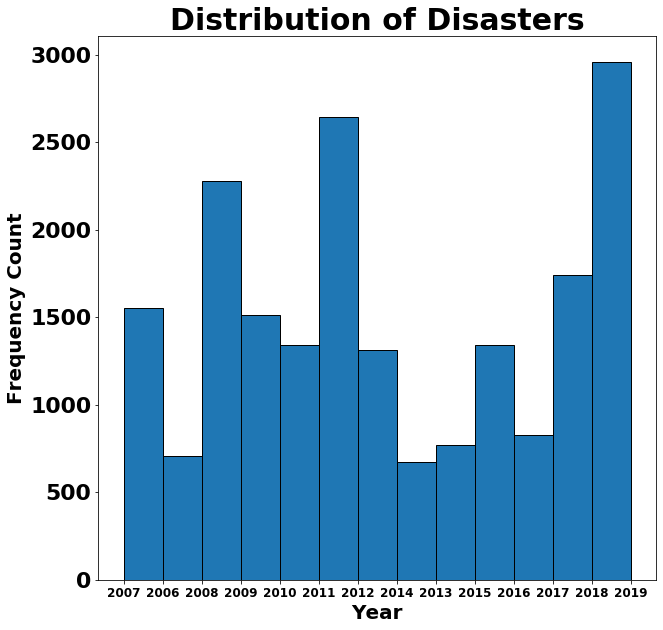

In [98]:
# distribution graph of the years
df_FEMA_new['Year'].hist(figsize = (10,10), bins=13, edgecolor='k')
plt.title("Distribution of Disasters", fontsize=30,fontweight='bold')
plt.ylabel("Frequency Count", fontsize=20,fontweight='bold')
plt.xlabel("Year", fontsize=20,fontweight='bold')
plt.xticks(fontsize= 12,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.grid(False)
plt.show();

The FEMA datasets had disasters as far back as 953 however since we are leveraging social media - we only cared about more recent dates. This graph shows the distribution of the counts of disasters. The distribution shows that there were a lot more declared disasters between 2008 - 2009, 2011-2012 and between 2018-2019. 

In [36]:
df_FEMA_open_data.to_csv('./df_fema.csv')

In [37]:
df_FEMA_open_data_flood = df_FEMA_open_data[df_FEMA_open_data['incidentType']=='Flood']

In [38]:
df_2015 = df_FEMA_open_data[df_FEMA_open_data['Month/Year']=='4/2015']

In [39]:
# look at more recent titles 
df_2015['title'].unique()

array(['SEVERE STORMS, TORNADOES, FLOODING, LANDSLIDES, AND MUDSLIDES',
       'SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSLIDES'], dtype=object)

In [40]:
df_FEMA_open_data_flood['title'].unique()

array(['FLOOD', 'FLOODS', 'FLOOD & EROSION', 'FLOOD & TORNADO',
       'FLOODS & RAINS', 'STORM & FLOOD', 'HEAVY RAINSTORMS & FLOOD',
       'HEAVY RAINSTORMS & FLOODS', 'HEAVY RAINS & FLOODS',
       'FLOODS & TORNADOES', 'SEVERE STORM, HIGH TIDES & FLOODING',
       'SEVERE STORMS, HIGH TIDES & FLOODING', 'ABNORMALLY HIGH TIDES',
       'SEVERE STORMS & FLOODING',
       'SEVERE STORMS, HEAVY RAINS & FLOODING', 'HEAVY RAINS & FLOODING',
       'FLOODING', 'SEVERE STORMS, HIGH WINDS & FLOODING',
       'HEAVY SNOWMELT, RAINS & FLOODING',
       'SEVERE STORMS, ICE JAMS & FLOODING', 'HEAVY RAINS & FLASH',
       'HEAVY RAINS, MELTING SNOWS & FLOODING', 'STORMS & FLOODING',
       'HEAVY RAINS, HIGH WINDS & FLOODING', 'WINDS, FLOODING, MUDSLIDES',
       'SEVERE STORMS & EXTENSIVE FLOODING', 'TROPICAL STORM AGNES',
       'FLOODING CAUSED BY LEVEE BREAK',
       'HIGH WINDS, WAVE ACTION & FLOODING',
       'SEVERE STORMS, SNOW MELT & FLOODING',
       'HEAVY RAINS, SNOWMELT AND FLOODING

This was necessary in deciding what key words to look at for the twitter scrapper. We scraped tweets with certain keywords that matched the unique title and that pertained to floods. When deciding on the date frame to look at we filtered by severe flood titles - we wanted to avoid storm or not severe storms from negatively impacting the model output.

In [41]:
#looking at these states that we will scrape from twitter 
df_NY = df_FEMA_open_data_flood[df_FEMA_open_data_flood['state'] == 'NY']
df_ME = df_FEMA_open_data_flood[df_FEMA_open_data_flood['state'] == 'ME']
df_CA = df_FEMA_open_data_flood[df_FEMA_open_data_flood['state'] == 'CA']
df_AK = df_FEMA_open_data_flood[df_FEMA_open_data_flood['state'] == 'AK']
df_ID = df_FEMA_open_data_flood[df_FEMA_open_data_flood['state'] == 'ID']

In [42]:
test = df_FEMA_open_data_flood[df_FEMA_open_data_flood['title']=='SEVERE STORMS AND FLOODING']
test['state'].value_counts()

TX    177
IA    121
LA     99
PA     71
NY     64
NE     54
MN     45
SC     36
AR     33
IN     31
MS     29
IL     28
SD     27
MI     24
VT     23
MO     14
OH     13
ND     11
NM     11
ME     10
OK      9
MD      6
TN      5
FL      4
WY      4
WV      2
HI      2
AZ      2
NH      2
NV      1
KS      1
Name: state, dtype: int64

First states we investigated was Texas and Iowa. Texas and Iowa have the highest of floods with the title - 'SEVERE STORMS AND FLOODING'. We decided to scrape tweets from those states. 

In [43]:
df_FEMA_open_data['title'].value_counts(normalize = True)

SEVERE STORMS AND FLOODING                     0.074036
SEVERE STORMS & FLOODING                       0.066391
HURRICANE KATRINA EVACUATION                   0.051004
SEVERE WINTER STORM                            0.037929
SEVERE STORMS, TORNADOES, AND FLOODING         0.035910
                                                 ...   
SEVERE STORMS, HAIL, FLOODING AND TORNADOES    0.000020
CA-CALAVERAS COMPLEX-08-07-2004                0.000020
SKIRBALL FIRE                                  0.000020
MONASTERY FIRE COMPLEX                         0.000020
SOUTH WENAS FIRE                               0.000020
Name: title, Length: 1812, dtype: float64

In [44]:
test[test['state']=='TX']['disasterNumber'].value_counts()

4272    46
1425    41
4416    36
4269    27
1179    21
4454     3
4377     3
Name: disasterNumber, dtype: int64

In [45]:
test[test['disasterNumber']== 4272];

In [46]:
TX_test = test[test['state']=='TX']
TX_test[TX_test['disasterNumber']==4272].describe()

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fyDeclared,placeCode
count,46.0,46.000000,46.0,46.000000,46.000000,46.0,46.000000
mean,4272.0,0.521739,0.0,0.956522,0.934783,2016.0,99235.956522
std,0.0,0.505047,0.0,0.206185,0.249637,0.0,152.345070
min,4272.0,0.000000,0.0,0.000000,0.000000,2016.0,99015.000000
25%,4272.0,0.000000,0.0,1.000000,1.000000,2016.0,99103.000000
50%,4272.0,1.000000,0.0,1.000000,1.000000,2016.0,99218.000000
75%,4272.0,1.000000,0.0,1.000000,1.000000,2016.0,99366.000000
max,4272.0,1.000000,0.0,1.000000,1.000000,2016.0,99477.000000


Based on the data, the incident we will scrape tweets from:
- TX
- 2016
- 5/22 - 6/24

In [49]:
#now looking at Texas in 2016 to decide dates where there weren't any floods 
report_2016 = df_FEMA_open_data[df_FEMA_open_data['Year']== '2016']

In [50]:
TX_2016 = report_2016[report_2016['state']=='TX']

In [51]:
TX_2016

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,state,declarationDate,fyDeclared,disasterType,incidentType,...,incidentEndDate,disasterCloseOutDate,declaredCountyArea,placeCode,hash,lastRefresh,id,Month/Year,Month,Year
41252,4266,0,0,1,1,TX,2016-03-19T17:35:00.000Z,2016,DR,Flood,...,2016-03-29T23:59:00.000Z,NaN,Sabine (County),99403.0,605424e9cc2d6ad571f8c358dce6fecc,2019-10-10T19:57:06.672Z,5d1bbdb28bdcfa6efb33b400,3/2016,3,2016
41259,4272,1,0,1,1,TX,2016-06-11T13:23:00.000Z,2016,DR,Flood,...,2016-06-24T23:59:00.000Z,NaN,Bastrop (County),99021.0,ed9eb0e378ceeaa49c188bf132b79935,2019-10-10T19:57:06.741Z,5d1bbdb28bdcfa6efb33b464,5/2016,5,2016
42010,4269,0,0,1,1,TX,2016-04-25T15:46:00.000Z,2016,DR,Flood,...,2016-04-30T23:59:00.000Z,NaN,Cass (County),99067.0,ab8d822608bfbaf2a4dc2ad6c74d0311,2019-10-10T19:57:06.741Z,5d1bbdb38bdcfa6efb33b4b3,4/2016,4,2016
42257,4272,0,0,1,0,TX,2016-06-11T13:23:00.000Z,2016,DR,Flood,...,2016-06-24T23:59:00.000Z,NaN,Hardin (County),99199.0,9cea00a0229eb6de2217ee61e765eff7,2019-10-10T19:57:06.735Z,5d1bbdb38bdcfa6efb33b4e2,5/2016,5,2016
42743,4266,1,0,1,1,TX,2016-03-19T17:35:00.000Z,2016,DR,Flood,...,2016-03-29T23:59:00.000Z,NaN,Gregg (County),99183.0,63b4e42023b6725035475a739d1fb280,2019-10-10T19:57:06.671Z,5d1bbdb28bdcfa6efb33b3f9,3/2016,3,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49368,4269,0,0,1,1,TX,2016-04-25T15:46:00.000Z,2016,DR,Flood,...,2016-04-30T23:59:00.000Z,NaN,Harrison (County),99203.0,cf51ddcb69dcdadccb45cb3c4bdbf928,2019-10-10T19:57:06.737Z,5d1bbdb28bdcfa6efb33b469,4/2016,4,2016
49389,4272,1,0,1,1,TX,2016-06-11T13:23:00.000Z,2016,DR,Flood,...,2016-06-24T23:59:00.000Z,NaN,Montgomery (County),99339.0,768a5b3b9aa0f2237dc0b0550194e464,2019-10-10T19:57:06.809Z,5d1bbdb38bdcfa6efb33b4d4,5/2016,5,2016
49396,4272,1,0,1,1,TX,2016-06-11T13:23:00.000Z,2016,DR,Flood,...,2016-06-24T23:59:00.000Z,NaN,Waller (County),99473.0,17fc9a0842f17b768511eafe245c76da,2019-10-10T19:57:06.732Z,5d1bbdb38bdcfa6efb33b4cd,5/2016,5,2016
49447,4269,1,0,1,1,TX,2016-04-25T15:46:00.000Z,2016,DR,Flood,...,2016-04-30T23:59:00.000Z,NaN,Harris (County),99201.0,7b62f7236c1594e5bbba69e4f5ea3f14,2019-10-10T19:57:06.737Z,5d1bbdb38bdcfa6efb33b49f,4/2016,4,2016


No events after June 2016, so will pick Aug 22-Sept 24 for our y=0 query.

Next we looked at the specific dates for Iowa. 

In [52]:
test[test['state']=='IA']['disasterNumber'].value_counts()

4421    80
1420    21
4289    19
4430     1
Name: disasterNumber, dtype: int64

In [53]:
test[test['disasterNumber']== 4289]

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,state,declarationDate,fyDeclared,disasterType,incidentType,...,incidentEndDate,disasterCloseOutDate,declaredCountyArea,placeCode,hash,lastRefresh,id,Month/Year,Month,Year
41461,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Buchanan (County),99019.0,1dd47f1fc8ae286fcb96c6abf2bf07d1,2019-10-10T19:57:07.027Z,5d1bbdb38bdcfa6efb33b58f,9/2016,9,2016-01-01
43056,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Black Hawk (County),99013.0,91ae45dee81a59b1e30cd04d550b36c5,2019-10-10T19:57:06.949Z,5d1bbdb38bdcfa6efb33b588,9/2016,9,2016-01-01
43746,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Franklin (County),99069.0,6b7002f793d2002108064367aecb9afd,2019-10-10T19:57:07.026Z,5d1bbdb38bdcfa6efb33b58b,9/2016,9,2016-01-01
43947,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Floyd (County),99067.0,8f575ce27e1434a68589c7e2e8ea506a,2019-10-10T19:57:06.951Z,5d1bbdb38bdcfa6efb33b589,9/2016,9,2016-01-01
45090,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Linn (County),99113.0,1c4ff5725f379c84ebe4df40c03bb3bc,2019-10-10T19:57:06.947Z,5d1bbdb38bdcfa6efb33b592,9/2016,9,2016-01-01
45176,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Butler (County),99023.0,5b32159ae7997eb48b80cd0be903ff75,2019-10-10T19:57:06.948Z,5d1bbdb38bdcfa6efb33b645,9/2016,9,2016-01-01
45975,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Chickasaw (County),99037.0,e9256108c65746646f5b34687d4c9594,2019-10-10T19:57:06.947Z,5d1bbdb38bdcfa6efb33b644,9/2016,9,2016-01-01
46086,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Allamakee (County),99005.0,f20fcfb2ba9b767d6850e4ddcd54b1a6,2019-10-10T19:57:07.027Z,5d1bbdb38bdcfa6efb33b58e,9/2016,9,2016-01-01
46991,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Clayton (County),99043.0,0050adf167cf4c8a12c9836fc2b494f3,2019-10-10T19:57:06.947Z,5d1bbdb38bdcfa6efb33b591,9/2016,9,2016-01-01
47161,4289,0,0,1,1,IA,2016-10-31T18:35:00.000Z,2017,DR,Flood,...,2016-10-03T23:59:00.000Z,NaN,Delaware (County),99055.0,60cda01d5983c8b93c95c3265045e674,2019-10-10T19:57:06.947Z,5d1bbdb38bdcfa6efb33b643,9/2016,9,2016-01-01


Incident 
- Iowa
- 2016
- 9/21/16 - 10/3/16, y=1
- 11/21/17-12/3/17, y=0

In [54]:
IA_test = test[test['state']=='IA']
IA_test.describe()

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fyDeclared,placeCode
count,121.000000,121.000000,121.000000,121.000000,121.0,121.000000,121.000000
mean,3879.512397,0.082645,0.173554,0.884298,1.0,2015.735537,98847.190083
std,1132.765386,0.276489,0.380300,0.321198,0.0,6.361038,2681.584259
min,1420.000000,0.000000,0.000000,0.000000,1.0,2002.000000,69600.000000
25%,4289.000000,0.000000,0.000000,1.000000,1.0,2017.000000,99043.000000
50%,4421.000000,0.000000,0.000000,1.000000,1.0,2019.000000,99087.000000
75%,4421.000000,0.000000,0.000000,1.000000,1.0,2019.000000,99135.000000
max,4430.000000,1.000000,1.000000,1.000000,1.0,2019.000000,99197.000000


In [55]:
floods = df_FEMA_open_data[df_FEMA_open_data['incidentType']=='Flood']

In [56]:
floods_recent = floods[floods['Year'] > '2015']

## EDA Visualizations

We looked at Frequency of Disaster, year and disaster, and the frequency of words used in titles. 

In [ ]:
df_top_disasters = df_FEMA_open_data.groupby(['incidentType']).size().sort_values(ascending=False).head(15)

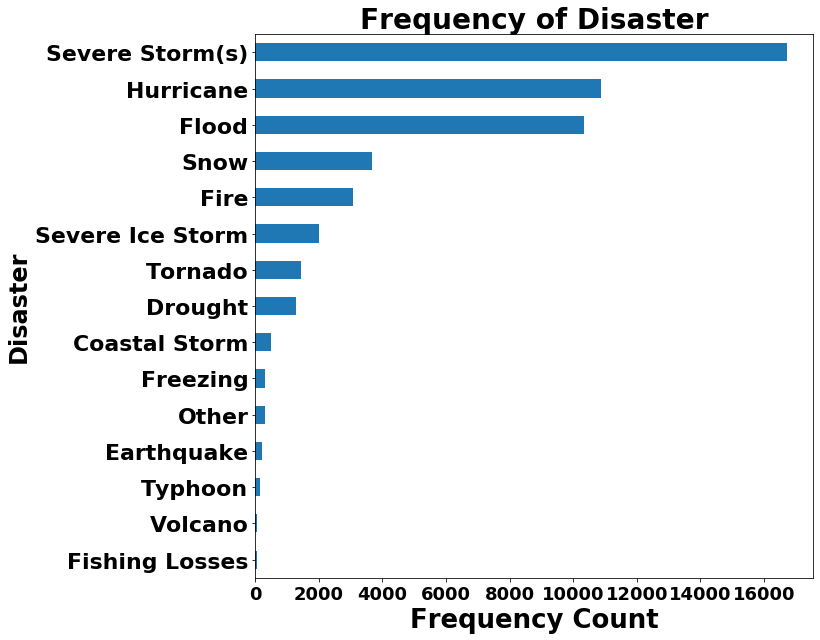

In [77]:
df_top_disasters.plot(kind='barh', figsize = (10,10))
plt.gca().invert_yaxis()
plt.title("Frequency of Disaster", fontsize=28,fontweight='bold')
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Disaster", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 18,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

In [78]:
df_FEMA_open_data[['state','incidentType']].count()

state           51016
incidentType    51016
dtype: int64

We thought it would be interesting to see the breakdown of storms by month and by year. 

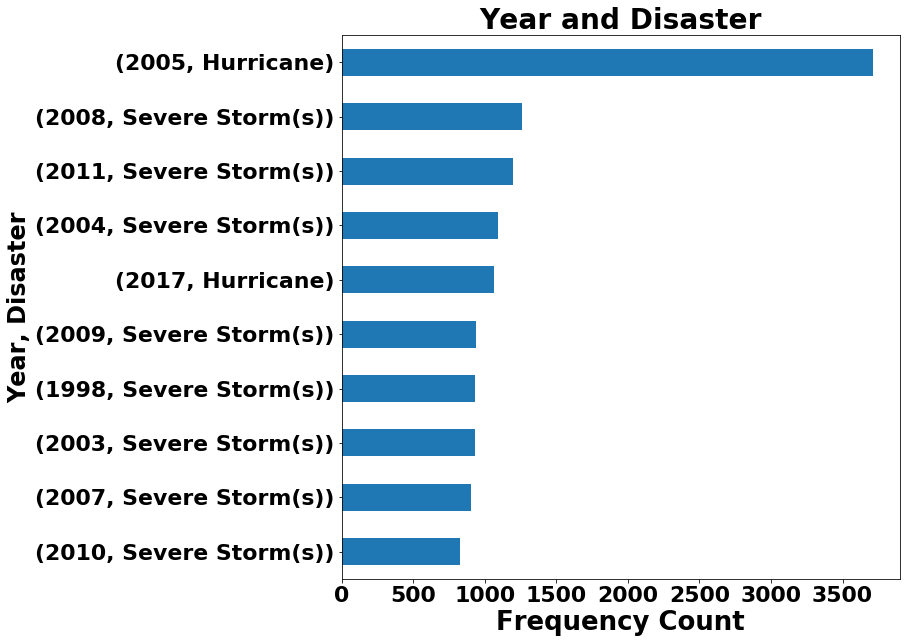

In [79]:
df_FEMA_open_data.groupby(['Year', 'incidentType']).size().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (10,10))
plt.gca().invert_yaxis()
plt.title("Year and Disaster", fontsize=28,fontweight='bold')
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Year, Disaster", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

The 2005 hurricane came up the most often. In addition to Katrina in 2005 there was alos Hurrican Rita and Wilma. 

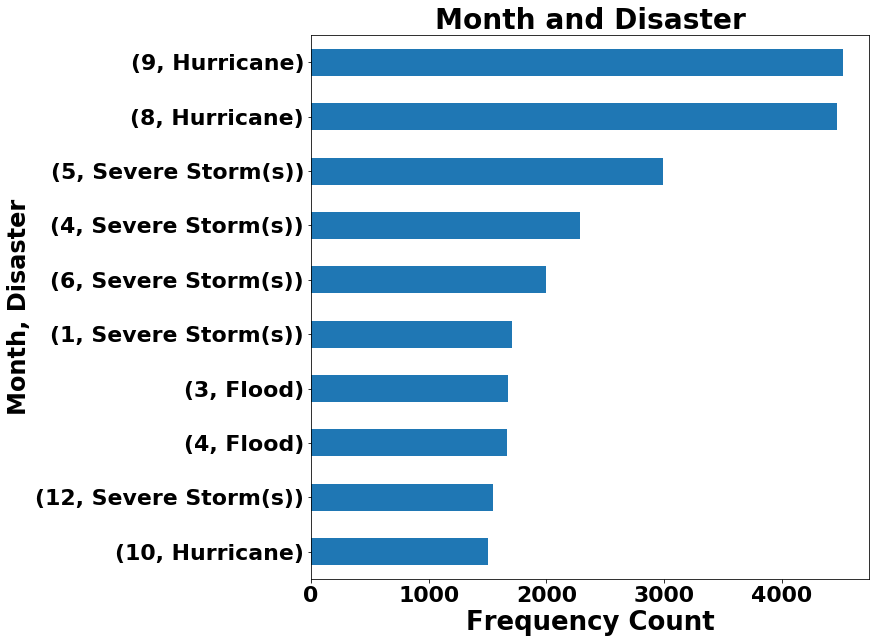

In [80]:
df_FEMA_open_data.groupby(['Month', 'incidentType']).size().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10,10))
plt.gca().invert_yaxis()
plt.title("Month and Disaster", fontsize=28,fontweight='bold')
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Month, Disaster", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

In [82]:
df_FEMA_open_data['incidentType_2'].astype(int)

0        22
1        22
2         1
3        22
4        22
         ..
51011    20
51012    20
51013    20
51014    20
51015    20
Name: incidentType_2, Length: 51016, dtype: int64

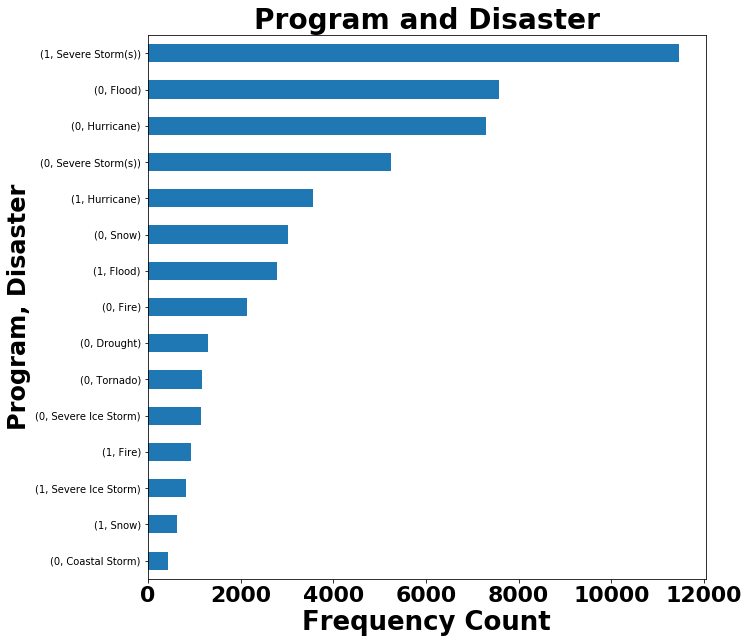

In [83]:
df_FEMA_open_data.groupby(['hmProgramDeclared', 'incidentType']).size().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10,10))
plt.gca().invert_yaxis()
plt.title("Program and Disaster", fontsize=28,fontweight='bold')
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Program, Disaster", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold');
           

This is a break down of the program and the type of storm. 

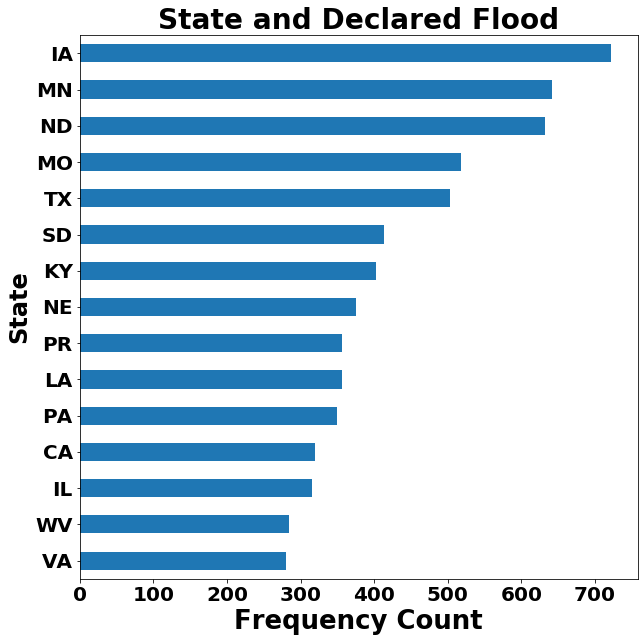

In [227]:
df_FEMA_open_data_flood.groupby(['state']).size().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10,10))
plt.gca().invert_yaxis()
plt.title("State and Declared Flood", fontsize=28,fontweight='bold')
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("State", fontsize=24,fontweight='bold')
plt.yticks(fontsize= 20,fontweight='bold')
plt.xticks(fontsize= 20,fontweight='bold');

This graph shows a break down of state anf the type of storm with the frequency count. Mosourri and sever storms had the highest total storms. 

In [86]:
df_top_words = word_count(df_FEMA_open_data['title']).head(15)

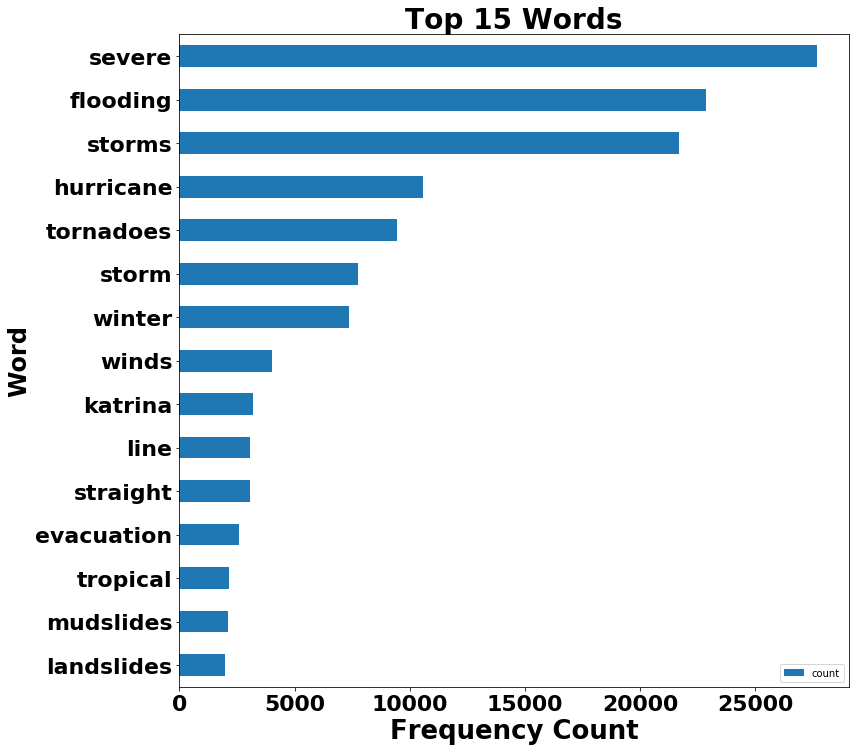

In [87]:
# top tweets in Wisconsin Floods
df_top_words.head(15).plot(kind='barh',figsize=(12,12))
plt.title("Top 15 Words", fontsize=28, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel("Frequency Count", fontsize=26,fontweight='bold')
plt.ylabel("Word", fontsize=24,fontweight='bold')
plt.xticks(fontsize= 22,fontweight='bold')
plt.yticks(fontsize= 22,fontweight='bold')
plt.show();

The top words from the FEMA titles. Severe was the most frequent since we specifically looked at that in order to verify that it was a legitimate flood.